In [1]:
!pip install -q transformers datasets accelerate bitsandbytes peft trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 504.6/504.6 kB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.7 MB/s eta 0:00:00


In [2]:
from huggingface_hub import notebook_login
notebook_login()

In [3]:
from datasets import load_dataset

data = load_dataset("openai_humaneval", split="test")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

openai_humaneval/test-00000-of-00001.par(…):   0%|          | 0.00/83.9k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/164 [00:00<?, ? examples/s]

In [4]:
data

Dataset({
    features: ['task_id', 'prompt', 'canonical_solution', 'test', 'entry_point'],
    num_rows: 164
})

In [5]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import prepare_model_for_kbit_training
import torch

model_name = "meta-llama/Meta-Llama-3-8B-Instruct"


# bits and bytes configuration
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
)

#load the model
model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb_config, device_map="auto")


model = prepare_model_for_kbit_training(model)


# load tokenizer for llama3
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

In [6]:
def format_humaneval(example):
    return {"text": example["prompt"] + example["canonical_solution"]}


# apply formatting to your dataset
formatted_dataset = data.map(format_humaneval, remove_columns=data.column_names)

Map:   0%|          | 0/164 [00:00<?, ? examples/s]

In [7]:
from peft import LoraConfig

# LoRA configuration
peft_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    lora_dropout=0.05,
    task_type="CAUSAL_LM"
)

In [8]:
torch.cuda.empty_cache()

In [9]:
from trl import SFTTrainer, SFTConfig

# define the training arguments
sft_args = SFTConfig(
    output_dir="content/drive/MyDrive/llama3-finetune-8B-instruct/outputs/adapter_model/",
    num_train_epochs=2,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    gradient_checkpointing=True,
    learning_rate=2e-4,
    logging_steps=5,
    optim="paged_adamw_8bit",
    save_strategy="epoch",
    bf16=True,
    report_to="none",
    max_length=128,
    packing=True
)

# initialize the SFTTrainer
trainer = SFTTrainer(
    model=model,
    train_dataset=formatted_dataset,
    peft_config=peft_config,
    args=sft_args,
    processing_class=tokenizer
)

/usr/local/lib/python3.11/dist-packages/trl/trainer/sft_trainer.py:449: UserWarning: Padding-free training is enabled, but the attention implementation is not set to 'flash_attention_2'. Padding-free training flattens batches into a single sequence, and 'flash_attention_2' is the only known attention mechanism that reliably supports this. Using other implementations may lead to unexpected behavior. To ensure compatibility, set `attn_implementation='flash_attention_2'` in the model configuration, or verify that your attention mechanism can handle flattened sequences.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/sft_trainer.py:495: UserWarning: You are using packing, but the attention implementation is not set to 'flash_attention_2'. Packing flattens batches into a single sequence, and 'flash_attention_2' is the only known attention mechanism that reliably supports this. Using other implementations may lead to cross-contamination between batches. To avoid this, ei

Adding EOS to train dataset:   0%|          | 0/164 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/164 [00:00<?, ? examples/s]

Packing train dataset:   0%|          | 0/164 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [10]:
print(f"GPU memory after model loading: {torch.cuda.memory_allocated()/1024**3:.2f} GB")

GPU memory after model loading: 5.34 GB


In [11]:
trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss
5,1.524800
10,1.293100
15,1.334700
20,1.320200
25,1.174300
30,1.127700
35,1.180000
40,1.146900


Training completed and model saved!


In [21]:
trainer.model.save_pretrained("/content/drive/MyDrive/llama3-finetune-8B-instruct/outputs/adapter_model/")
tokenizer.save_pretrained("/content/drive/MyDrive/llama3-finetune-8B-instruct/outputs/adapter_model/")

('/content/drive/MyDrive/llama3-finetune-8B-instruct/outputs/adapter_model/tokenizer_config.json',
 '/content/drive/MyDrive/llama3-finetune-8B-instruct/outputs/adapter_model/special_tokens_map.json',
 '/content/drive/MyDrive/llama3-finetune-8B-instruct/outputs/adapter_model/chat_template.jinja',
 '/content/drive/MyDrive/llama3-finetune-8B-instruct/outputs/adapter_model/tokenizer.json')

In [34]:
adapter_path = "/content/drive/MyDrive/llama3-finetune-8B-instruct/outputs/adapter_model/"

# load and merge lora adapter
fine_tuned_model = PeftModel.from_pretrained(model, adapter_path)

# pipeline for text generation
pipe = pipeline(
    task="text-generation",
    model=fine_tuned_model,
    tokenizer=tokenizer,
    max_new_tokens=256,
    temperature=0.7,
)

/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:190: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/peft_model.py:585: UserWarning: Found missing adapter keys while loading the checkpoint: ['base_model.model.base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight', 'base_model.model.base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight', 'base_model.model.base_model.model.model.layers.0.self_attn.k_proj.lora_A.default.weight', 'base_model.model.base_model.model.model.layers.0.self_attn.k_proj.lora_B.default.weight', 'base_model.model.base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight', 'base_model.model.base_model.model.model.layers.0.self_attn.v_proj.lora_B.default.weight', 'base_model.model.base_model.model.model.layers.0.self_attn.o_proj.

In [44]:
# takes user input for prompt
user_query = input("Enter your coding prompt: ")

# format the user prompt
prompt = f"""<|begin_of_text|><|start_header_id|>user<|end_header_id|>
{user_query}<|eot_id|><|start_header_id|>assistant<|end_header_id|>"""

# run the inference
result = pipe(prompt)

# get the full generated text
output = result[0]['generated_text']

# slice the output string to remove the prompt
response = output[len(prompt):]

print(response)

Enter your coding prompt: function to check whether a number is odd or even


Here is a simple function in JavaScript to check whether a number is odd or even:
```
function isOddOrEven(n) {
  if (n % 2 === 0) {
    return "even";
  } else {
    return "odd";
  }
}
```
This function takes an integer `n` as input and returns a string indicating whether it's odd or even.

Here's how it works:

* `n % 2` calculates the remainder of `n` divided by 2.
* If the remainder is 0, the number is even.
* If the remainder is not 0, the number is odd.

You can use this function like this:
```
console.log(isOddOrEven(4)); // Output: "even"
console.log(isOddOrEven(3)); // Output: "odd"
```
Alternatively, you can also use the ternary operator to make the function more concise:
```
function isOddOrEven(n) {
  return n % 2 === 0? "even" : "odd";
}
```
This function is equivalent to the previous one, but is a bit more concise.


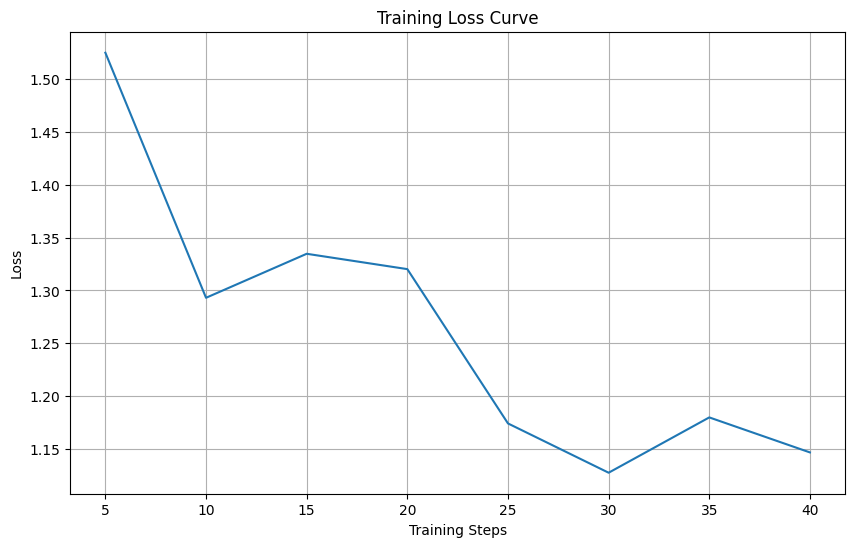

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

# access the training logs
log_history = trainer.state.log_history

# convert the logs to a pandas DataFrame
df = pd.DataFrame(log_history)

# filter for training loss entries (excluding evaluation steps if any)
training_logs = df[df['loss'].notna()].copy()

# plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(training_logs['step'], training_logs['loss'])
plt.title("Training Loss Curve")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.grid(True)
plt.show()